In [23]:
from __future__ import division
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import PIL
import numba
import scipy.io
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm, poisson
from joblib import Parallel, delayed
import pfmreader

In [24]:
cam0=[[3979.911, 0, 1244.772], [0, 3979.911, 1019.507], [0, 0, 1]]
cam1=[[3979.911, 0, 1369.115], [0, 3979.911, 1019.507], [0, 0, 1] ]
f = cam0[0][0]
doffs=124.343
baseline=193.001
width=2964
height=2000
ndisp=270
isint=0
vmin=23
vmax=245
dyavg=0
dymax=0

(334, 494)
[[ 4.73753357  4.73909664  4.74902773 ...,  3.53796291  3.54097724
   3.76654935]
 [ 4.73890018  4.74058723  4.74896288 ...,  3.54027319  3.53987527
   3.76864552]
 [ 4.74246979  4.74396896  4.7503829  ...,  3.5426538   3.51995254
   3.77142429]
 ..., 
 [ 2.14307046  2.14338946  2.14351106 ...,  2.20156908  2.20186853
   2.20219827]
 [ 2.13679218  2.13705134  2.13723445 ...,  2.19536448  2.19538903
   2.19566131]
 [ 2.13102698  2.13086939  2.13098145 ...,  2.19170451  2.18815398
   2.18982458]]


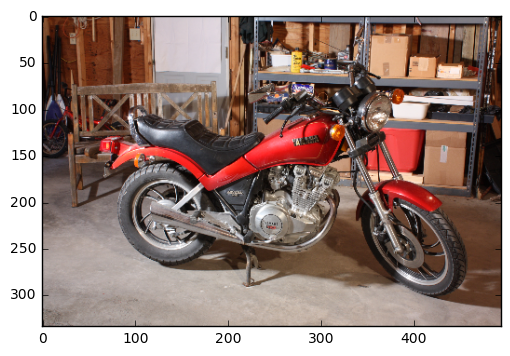

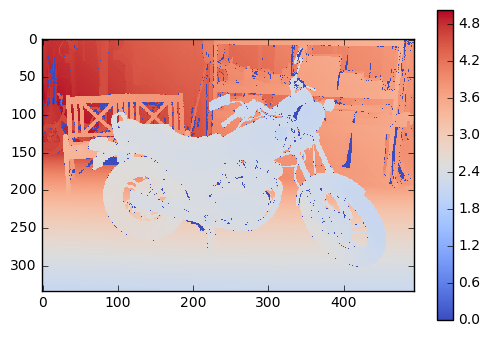

In [25]:
img = PIL.Image.open('depth_maps/im0.png')
# plt.imshow(img)
with open('depth_maps/disp0.pfm') as ff:
    d = pfmreader.load_pfm(ff)
    
Z = baseline * f / (d[0] + doffs) # mm
Z *= 1e-3
# Downsample
Z = Z[::6,::6]
Z = Z[::-1,:]
print Z.shape
print Z
color_img = np.array(img)[::6,::6,:]
plt.imshow(color_img)
plt.show()
plt.imshow(Z, cmap='coolwarm', interpolation='none')
plt.colorbar()

In [26]:
# This code creates a histogram of photon detections, and then creates the
# Coates and MAP solutions.

from __future__ import division
from scipy.stats import norm, poisson, rv_discrete
import numpy as np
import matplotlib.mlab as mlab

np.random.seed(0)
# Constants.
I = 1 # photons/laser pulse
QE = 1;#.30; #Quantum efficiency
DC = 0#1e-5;  # dark counts per exposure
amb = 0#1e-5; # ambient light
bucket_size = 50e-12
T = 500;
times = np.arange(0,T) 

# Make a pulse centered at d.
c = 3e8 # speed of light

mu_laser = 0#2*d/c
wavelength = 455e-9 # nanometers
FWHM_laser = 50e-12
sigma_laser = FWHM_laser/(2*np.sqrt(2*np.log(2)))
# FWHM = 2 sqrt(2ln(2))sigma
mu_spad = 0
FWHM_spad = 50e-12
sigma_spad = FWHM_spad/(2*np.sqrt(2*np.log(2)))

sigma_true = np.sqrt(sigma_spad**2 + sigma_laser**2)

GLOBAL_OFFSET = 5/c

def depth2mag(d, diameter=40e-3):
    if d == 0:
        return 1
    else:
        # Decay magnitude based on depth.
        return np.pi*(diameter/2)**2/(2*np.pi*d**2)

def get_pulse(d):
    if d == 0:
        return np.zeros(T)
    offset = 2*d/c - GLOBAL_OFFSET
    tmp = norm.cdf((times+1)*bucket_size, 
             loc=mu_laser+mu_spad + offset, 
             scale=np.sqrt(sigma_spad**2 + sigma_laser**2) )

    diff = norm.cdf(times*bucket_size, 
                 loc=mu_laser+mu_spad + offset, 
                 scale=np.sqrt(sigma_spad**2 + sigma_laser**2) )
    return tmp - diff
print "getting r"
r = np.zeros(list(Z.shape) + [T])
for i in range(100):#Z.shape[0]):
    if i % 50 == 0:
        print i
    for j in range(100):#Z.shape[1]):
        r[i,j,:] = get_pulse(Z[i,j])*depth2mag(Z[i,j])
 

true_r = r

# plt.savefig('laser-pulse')

getting r
0
50


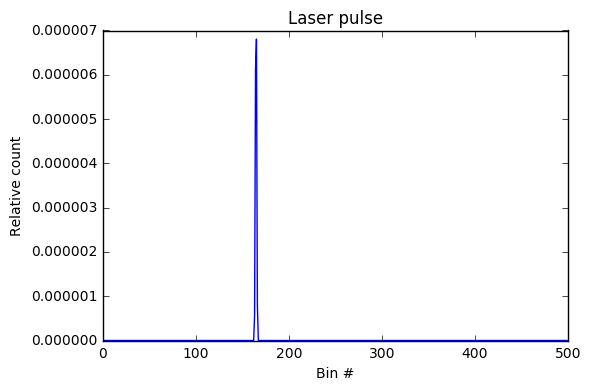

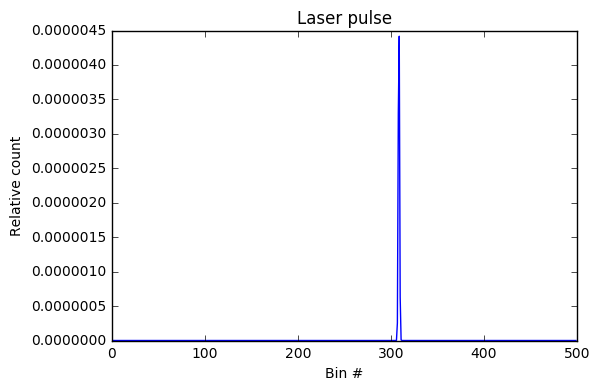

In [27]:
plt.plot(r[80,80,:])
plt.ylabel('Relative count')
plt.xlabel('Bin #')
plt.title('Laser pulse')
plt.show()

plt.plot(r[50,50,:])
plt.ylabel('Relative count')
plt.xlabel('Bin #')
plt.title('Laser pulse')

In [28]:

@numba.jit(nopython=True)
def run_trial(counts):
    min_so_far = np.inf # min of T means not detected.
    for t, nt in enumerate(counts):
        if nt > 0:
            hits = t
            if hits < min_so_far:
                if 0 <= hits < T:
                    min_so_far = hits
                # Project firing times onto [0,T-1].
                elif hits < 0:
                    min_so_far = 0
                else:
                    min_so_far = T - 1
    return min_so_far

def get_buckets(N, I, r):
    lamb = QE*(I*r + amb) + DC
    hist = np.zeros((N, 1))
    counts = np.random.poisson(np.tile(lamb[:,None], N))
    for trial in range(N):
        min_so_far = run_trial(counts[:,trial])
        hist[trial] = min_so_far

    # Get histogram:
    buckets = np.zeros(T)
    for t in range(T):
        buckets[t] = np.sum(hist == t)
    total_misses = N - buckets.sum()
#     print "misses = ", total_misses
    return buckets

In [29]:
def coates(T, N, h):
    r = np.zeros(T)
    r[0] = -np.log(1-h[0]/N)
    for k in range(1,T):
        tmp = N - np.sum(h[:k])
        # TODO: Unclear what to do here.
        if tmp == 0 or h[k]/tmp == 1:
            r[k] = 0
        else:
            r[k] = -np.log(1-h[k]/tmp)
    return r

# r_c = coates(T, NUM_TRIALS, buckets)

In [30]:
def fit_gaussian(hist):
    if hist.sum() == 0:
        return np.random.random()*T*bucket_size
    hist = hist/hist.sum()
    SCALE = 1
    x = (times*bucket_size + bucket_size/2)*SCALE
    n = len(x)
    mean = sum(x*hist)
#     return mean
    sigma = np.sqrt(sum(hist*(x-mean)**2))
    def gauss(x,a,x0):
        return a*np.exp(-(x-x0)**2/(2*sigma_true**2))
    try:
        popt,pcov = curve_fit(gauss, x, hist, p0=[hist.max(), mean])
    except RuntimeError as e:
        popt = 1, T/2*bucket_size
    intensity, mean = popt
#     print intensity, mean/SCALE, var/SCALE
    estimate = mean/SCALE
#     print hist.sum()*hist.max()
    return max(0, min(estimate, T*bucket_size))

# estimate = fit_gaussian(buckets)
# print "Gaussian fit in mm = ", c*estimate/2*1000
# print 500*c*(buckets[np.argmax(hist)] + bucket_size/2)

In [31]:
SCALE = 1/bucket_size
# SCALE = 1

def F(buckets, offset):
    return norm.cdf(buckets, loc=offset,
        scale=sigma_true*SCALE)

def pdf_f(buckets, offset):
    return norm.pdf(buckets, loc=offset,
        scale=sigma_true*SCALE)

def get_pdf(t, I, hist, num_trials, buckets, bucket_size):
    # Get MAP estimate of initial time.
    # Pr(observations | t_0) = \Prod_{i=1}^N Pr(t_i in bucket I_i).
    # = Pr(t_i in bucket I_i) = \sum_{n=0}^\infty Pr(t_i in bucket I_i | n)Pr(n)
    # Pr(t_i in bucket I_i | n) = CDF(I_i max | n) - CDF(I_i min | n)
    bucket_probs = np.exp(-F(buckets, t)*I) - np.exp(-F(buckets + bucket_size, t)*I)
    prob = hist*np.log(np.maximum(bucket_probs, 1e-100)) 
    return prob.sum() - I*(num_trials - hist.sum())

def get_derivative(t, I, hist, num_trials, buckets, bucket_size):
    # Derivative with respect to I.
    Ft = F(buckets, t)
    Ftdelta = F(buckets + bucket_size, t)
    bucket_probs = np.exp(-Ft*I) - np.exp(-Ftdelta*I)
    tmp = -Ft*np.exp(-Ft*I) + Ftdelta*np.exp(-Ftdelta*I)
    dI = hist.dot( tmp/np.maximum(bucket_probs, 1e-100) ) - (num_trials - hist.sum())
#     print dI
    
    # Derivative with respect to t.
    tmp = -I*pdf_f(buckets, t)*np.exp(-Ft*I) + I*pdf_f(buckets + bucket_size, t)*np.exp(-Ftdelta*I)
    dt = hist.dot( tmp/np.maximum(bucket_probs, 1e-100) )
#     print dt
    return np.array([dt, dI])

def optimize(t0, I0, hist, num_trials, buckets, bucket_size):
    def obj(x):
        return -get_pdf(x[0], x[1], hist, num_trials, buckets, bucket_size)
    
    def jac(x):
        return -get_derivative(x[0], x[1], hist, num_trials, buckets, bucket_size)
    
    result = minimize(obj, np.array([t0, I0]), method='TNC', jac=jac, bounds=[(0,100*bucket_size*SCALE), (1e-4,25)])
    print result
    return result.x[0], result.x[1]
#     return result.x, I0

def get_max(offsets, intensities, hist, num_trials, buckets, bucket_size):
    best_so_far = -np.inf
    best_arg = (0, 0)
    for i, offset in enumerate(offsets):
        for j, intensity in enumerate(intensities):
            prob = get_pdf(offset, intensity, hist, num_trials, buckets, bucket_size)
            if prob > best_so_far:
                best_so_far = prob
                best_arg = (i, j)
    return offsets[i], intensities[j]

In [32]:
# Make plot of error vs # photons

# REPS = 10
# SCALE = 1e9
# NUM_TRIALS = int(1e5)

def get_errors(NUM_TRIALS, photons, i, j, correct=False):
    errors = np.zeros(photons.size)
    for idx, photon_count in enumerate(photons):
        avg_error = 0
        for rep in range(1):
            buckets = get_buckets(NUM_TRIALS, photon_count, true_r[i,j,:])
            if correct:
                hist = coates(T, NUM_TRIALS, buckets)
                estimate = fit_gaussian(hist)
#                 estimate, intensity = optimize(gauss_estimate*SCALE, hist.sum(), 
#                                             buckets, NUM_TRIALS, times*bucket_size*SCALE, bucket_size*SCALE)
#                 estimate, intensity = get_max(np.linspace(-.1,.1, num=100)*bucket_size + gauss_estimate,
#                                               np.linspace(1/1.2,1.2, num=100)*hist.sum(),
#                                               buckets, NUM_TRIALS, times*bucket_size*SCALE, bucket_size*SCALE)
#                 estimate /= SCALE
#                 print estimate, intensity, photon_count, gauss_estimate, hist.sum() 
#                 print "prob of truth = ", get_pdf(50*bucket_size, photon_count, buckets, 
#                                                   NUM_TRIALS, times*bucket_size, bucket_size)
#                 print "prob of guess = ", get_pdf(estimate, intensity, buckets, 
#                                   NUM_TRIALS, times*bucket_size, bucket_size)
            else:
                hist = buckets
                estimate = fit_gaussian(hist)
            d_est = c*(estimate + GLOBAL_OFFSET)/2
#             print d_est, c*gauss_estimate/2*1000
#             print d_est, c*np.sum(hist/hist.sum()*(times+.5)*bucket_size)/2*1000
            avg_error += 1000*(d_est - Z[i,j]) #NOTE not abs any more!
        errors[idx] = avg_error
    return errors

In [33]:
photons = np.logspace(4, 6, num=20)#*45e6

def parallel_run(data):
    x, N, photons, (i, j), correct = data
    np.random.seed(x)
    return get_errors(N, photons, i,j, correct)


In [132]:
REPS = 25
data = zip(range(REPS), [int(1e5)]*REPS, [photons]*REPS, [(50,50)]*REPS, [True]*REPS)
vals = Parallel(n_jobs=REPS)(delayed(parallel_run)(i) for i in data)
pc_errors = sum([abs(v) for v in vals])/REPS

In [133]:
REPS = 25
data = zip(range(REPS), [int(1e5)]*REPS, [photons]*REPS, [(50,50)]*REPS, [False]*REPS)
vals = Parallel(n_jobs=REPS)(delayed(parallel_run)(i) for i in data)
raw_errors = sum([abs(v) for v in vals])/REPS

In [134]:
# Error is in the sub-mm range for corrected vs. mm range for uncorrected.
print pc_errors
print raw_errors
print (10*np.log10(750/pc_errors)).max() 
print (10*np.log10(750/raw_errors)).max()
print raw_errors.min()/pc_errors.min()

[ 0.05123524  0.04899499  0.03582337  0.03869228  0.03695488  0.03280722
  0.02650084  0.02171702  0.01838418  0.02594845  0.01560164  0.02074972
  0.01733446  0.02208267  0.02324094  0.02795097  0.02475946  0.04409672
  0.05285075  0.1310145 ]
[ 0.13076701  0.17622461  0.21343311  0.25003743  0.30800681  0.43388413
  0.53784763  0.68273757  0.86278381  1.09528042  1.37407794  1.72820833
  2.15179559  2.64332543  3.21338149  3.81206634  4.45161746  5.09529444
  5.7236871   6.33476973]
46.8189099139
37.5856308549
8.38161881693


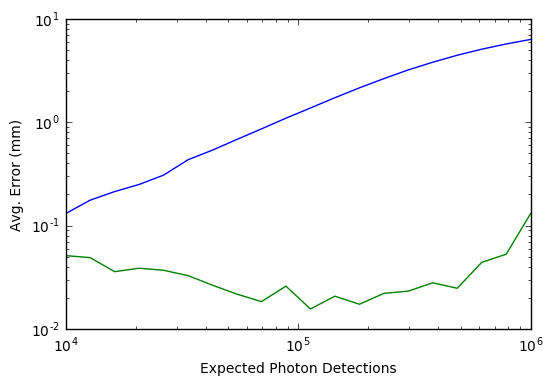

In [135]:
plt.xlabel('Expected Photon Detections')
plt.ylabel('Avg. Error (mm)')
plt.loglog(photons, raw_errors, label='Raw')
plt.loglog(photons, pc_errors, label='Pile-Up Correction')

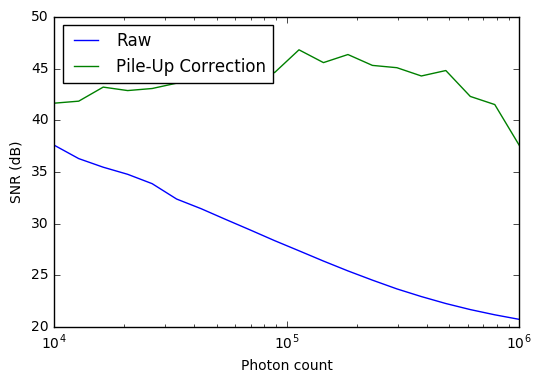

In [136]:
plt.xlabel('Photon count')
plt.ylabel('SNR (dB)')
plt.semilogx(photons, 10*np.log10(750/raw_errors), label='Raw')
plt.semilogx(photons, 10*np.log10(750/pc_errors), label='Pile-Up Correction')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Plot error, SNR, more trials so smoother
# combine gaussian fitting + pile-up correction
REPS = 5
NCPUS = 100
raw_errors = range(REPS)
pc_errors = range(REPS)

for rep in range(REPS):
    print rep
    raw_list = []
    pc_list = []
    # photons = np.logspace(-4, 1, num=20)
    #num_trial_list = [int(val) for val in np.logspace(4, 6, num=5)]
    photons = np.logspace(4, 6, num=10)#*45e6
    N = int(1e3)
    # ij_vals = [(i, j) for i in range(Z.shape[0]) for j in range(Z.shape[1])]
    ij_vals = [(i, j) for i in range(100) for j in range(100)]

    data = zip(range(len(ij_vals)), [N]*len(ij_vals), [photons]*len(ij_vals), ij_vals, [False]*len(ij_vals))
    raw_errors[rep] = Parallel(n_jobs=NCPUS)(delayed(parallel_run)(i) for i in data)

    data = zip(range(len(ij_vals)), [N]*len(ij_vals), [photons]*len(ij_vals),  ij_vals, [True]*len(ij_vals))
    pc_errors[rep] = Parallel(n_jobs=NCPUS)(delayed(parallel_run)(i) for i in data)

0


In [ ]:
raw_MSE = np.zeros(len(photons))
pc_MSE = np.zeros(len(photons))

for rep in range(REPS):
    # Assemble errors into HxWx photons
    raw_map = np.zeros((Z.shape[0], Z.shape[1], len(photons)))
    pc_map = np.zeros((Z.shape[0], Z.shape[1], len(photons)))
    for idx, (i,j) in enumerate(ij_vals):
        raw_map[i,j,:] = raw_errors[rep][idx]
        pc_map[i,j,:] = pc_errors[rep][idx]

    # Remove outliers.
    pc_map[pc_map > 1000] = 0
    raw_map[raw_map > 1000] = 0

    for idx, count in enumerate(photons): 
        pc_MSE[idx] += np.mean(np.square(pc_map[:100,:100,idx]))/REPS
        raw_MSE[idx] += np.mean(np.square(raw_map[:100,:100,idx]))/REPS

In [ ]:
print raw_MSE.min()/pc_MSE.min()

plt.xlabel('Expected Photon Detections')
plt.ylabel('MSE (mm)')
plt.loglog(photons, raw_MSE, label='Raw')
plt.loglog(photons, pc_MSE, label='Pile-Up Correction')
plt.legend(loc='upper left')
# plt.savefig('MSE-1e2trials.png')

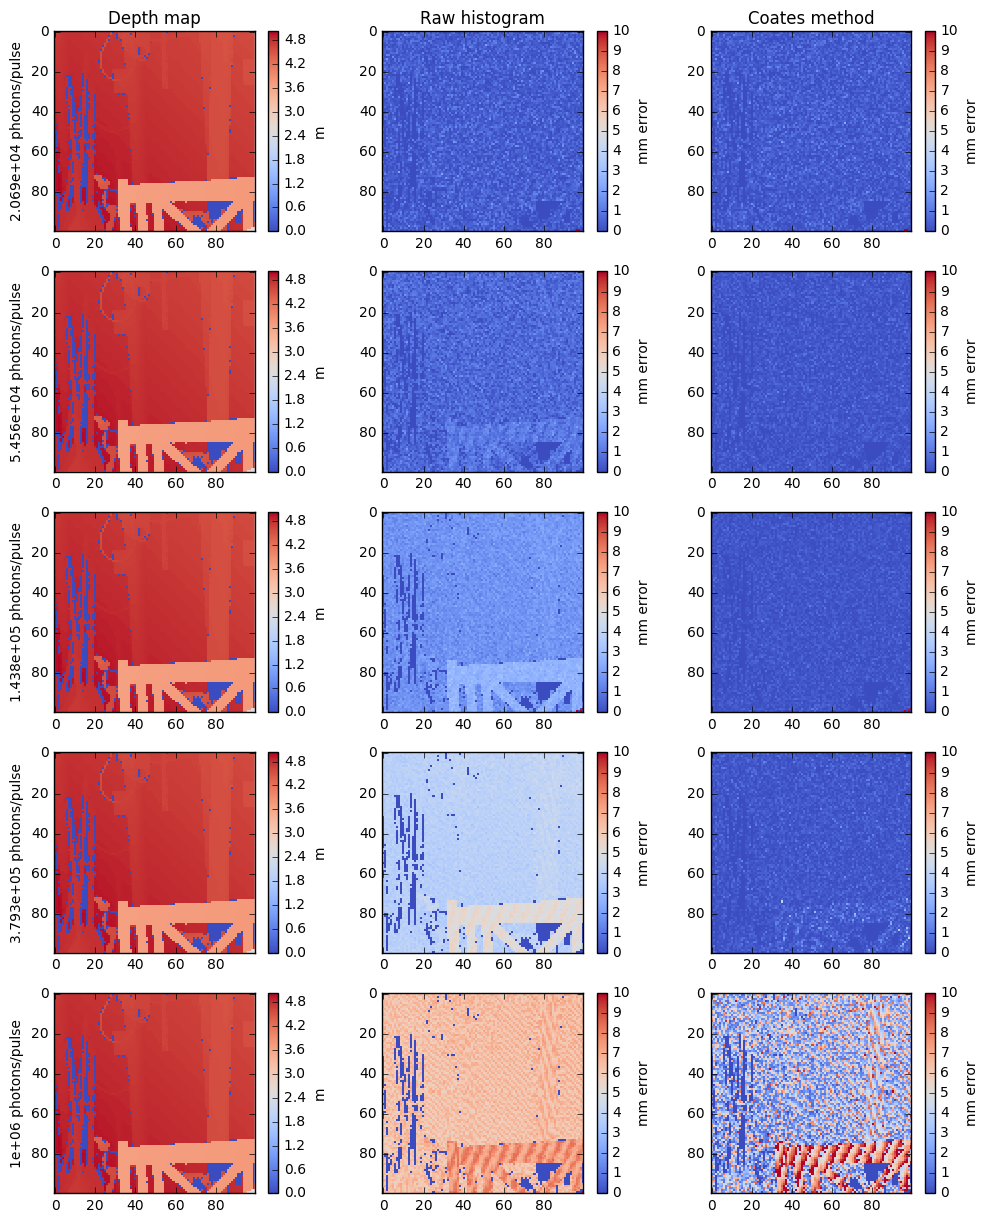

In [69]:
plt.figure(figsize=(12,15))
photon_sel = photons[3::4]
for idx, count in enumerate(photon_sel): 
    photon_idx = list(photons).index(count)
    #plt.title('%s trials, avg. photon count %f' % (N, count))
    plt.subplot(len(photon_sel),3,1+idx*3)
    if idx == 0:
        plt.title('Depth map')
    plt.imshow(Z[:100,:100], cmap='coolwarm', interpolation='none')
    plt.colorbar(label='m')
    plt.ylabel('%.4g photons/pulse' % count)
    
    plt.subplot(len(photon_sel),3,2+idx*3)
    if idx == 0:
        plt.title('Raw histogram')
    plt.imshow(abs(raw_map[:100,:100, photon_idx]), cmap='coolwarm', interpolation='nearest', vmin=0, vmax=10)
    plt.colorbar(label='mm error')
    
    plt.subplot(len(photon_sel),3,3+idx*3)
    if idx == 0:
        plt.title('Coates method')
    plt.imshow(abs(pc_map[:100,:100, photon_idx]), cmap='coolwarm', interpolation='nearest', vmin=0, vmax=10)
    plt.colorbar(label='mm error')
# plt.show()
# plt.savefig('lens-1e3trials-subsample.png')

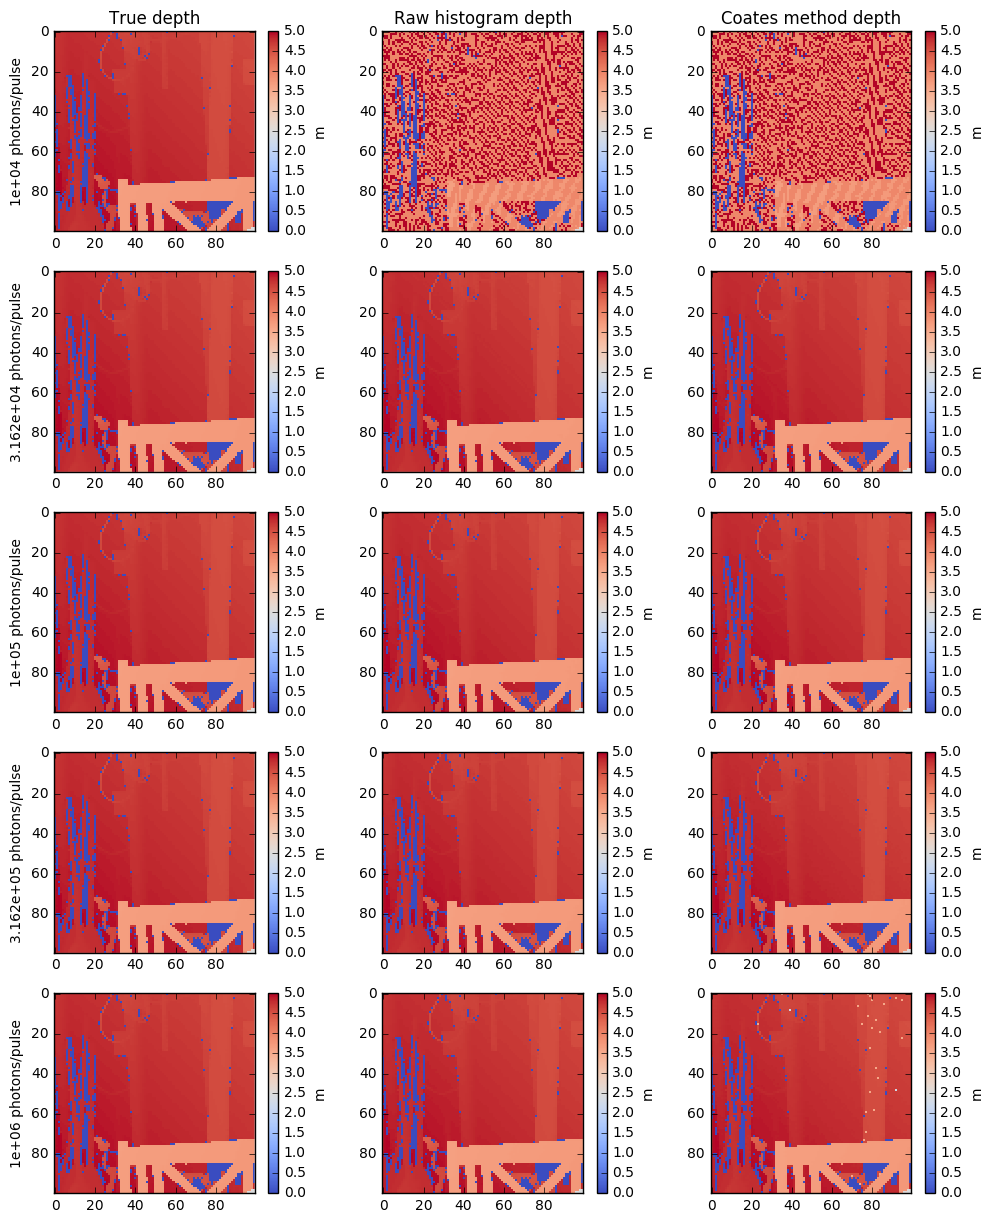

In [92]:
# Make depth maps.
def get_new_depth(error, depth, max_val=1000):
    sel = depth != 0
    result = depth.copy()
    result[sel] += error[sel]*1e-3
    return result

plt.figure(figsize=(12,15))
for idx, count in enumerate(photons): 
    #plt.title('%s trials, avg. photon count %f' % (N, count))
    
    plt.subplot(len(photons),3,1+idx*3)
    if idx == 0:
        plt.title('True depth')
    plt.imshow(Z[:100,:100], cmap='coolwarm', interpolation='none', vmin=0, vmax=5.0)
    plt.colorbar(label='m')
    plt.ylabel('%.4g photons/pulse' % count)
    
    plt.subplot(len(photons),3,2+idx*3)
    if idx == 0:
        plt.title('Raw histogram depth')
    plt.imshow(get_new_depth(raw_map[:100,:100, idx], Z[:100,:100]), cmap='coolwarm', 
               interpolation='none', vmin=0, vmax=5.0)
    plt.colorbar(label='m')
    
    plt.subplot(len(photons),3,3+idx*3)
    if idx == 0:
        plt.title('Coates method depth')
    plt.imshow(get_new_depth(pc_map[:100,:100, idx], Z[:100,:100]), cmap='coolwarm', 
               interpolation='none', vmin=0, vmax=5.0)
    plt.colorbar(label='m')
plt.show()
# plt.savefig('lens-1e1trials-depth.png')

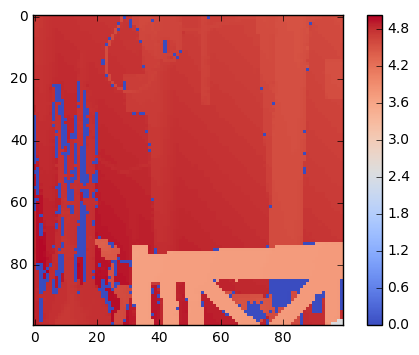

In [247]:
plt.imshow(Z[:100,:100], cmap='coolwarm', interpolation='none')
plt.colorbar()

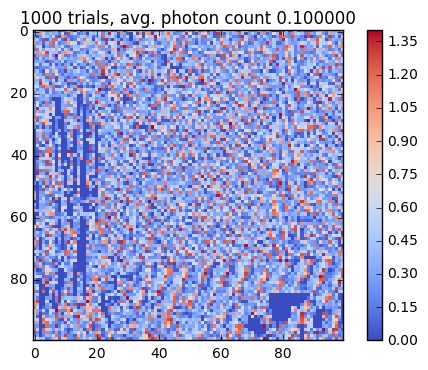

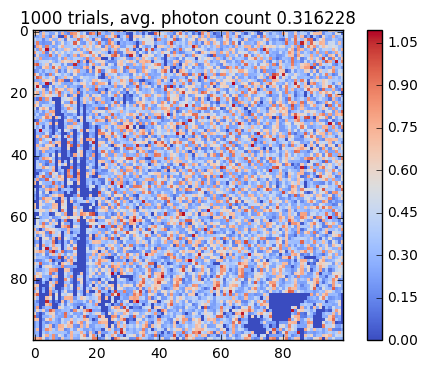

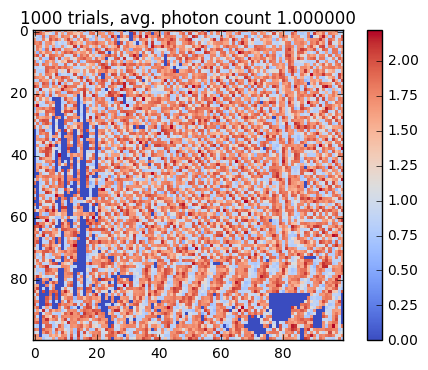

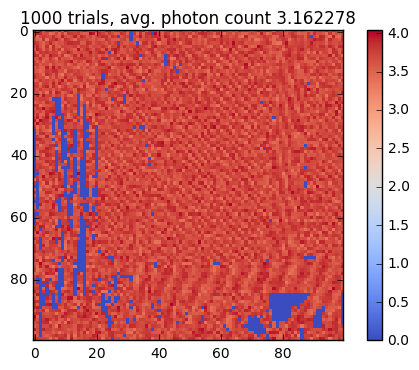

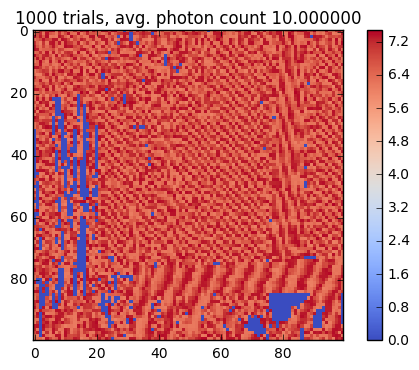

In [249]:
for idx, count in enumerate(photons):
    plt.title('%s trials, avg. photon count %f' % (N, count))
    plt.imshow(raw_map[:100,:100, idx], cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [163]:
#

In [15]:
print np.logspace(4,6,num=5)
print 10*np.log10(750/raw_list[-1]).max()
print 10*np.log10(750/pc_list[-1]).max()

[   10000.            31622.77660168   100000.           316227.76601684
  1000000.        ]
43.7967769177
52.3932363648


In [16]:
scipy.io.savemat('20ps-bin-50ps-laser-SNR', {'photon_count':photons, 'num_trials':num_trial_list, 
 'raw_error':np.vstack(raw_list),
 'pc_error':np.vstack(pc_list),})

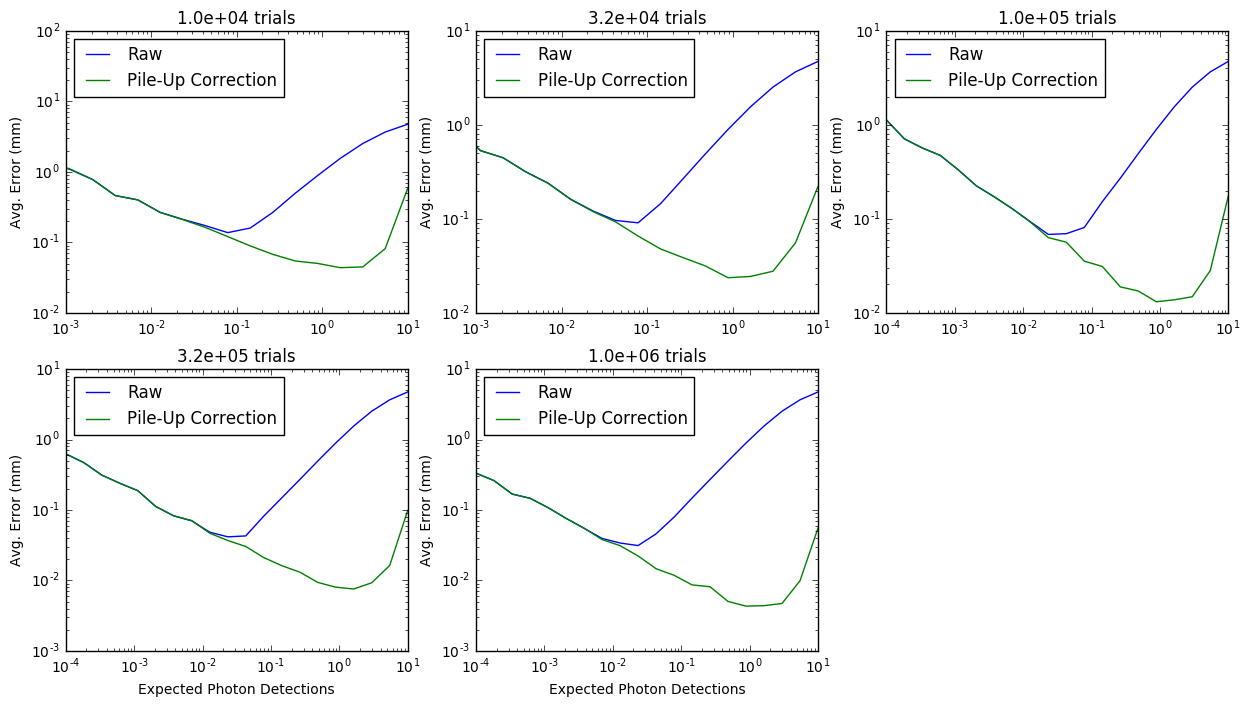

In [17]:
error_data = scipy.io.loadmat('20ps-bin-50ps-laser-SNR')
plt.figure(figsize=(15,8))
for idx, N in enumerate(num_trial_list):
    plt.subplot(2,3,idx+1)
    if idx > 2:
        plt.xlabel('Expected Photon Detections')
    plt.ylabel('Avg. Error (mm)')
    plt.loglog(photons, error_data['raw_error'][idx], label='Raw')
    plt.loglog(photons, error_data['pc_error'][idx], label='Pile-Up Correction')
    if N in num_trial_list[:2]:
        plt.xlim([1e-3, 10])
#         plt.ylim([1e-1, 100])
    plt.legend(loc='upper left')
    plt.title("%.1e trials" % N)
plt.savefig('20ps-bin-error-raw-vs-coates-50ps')

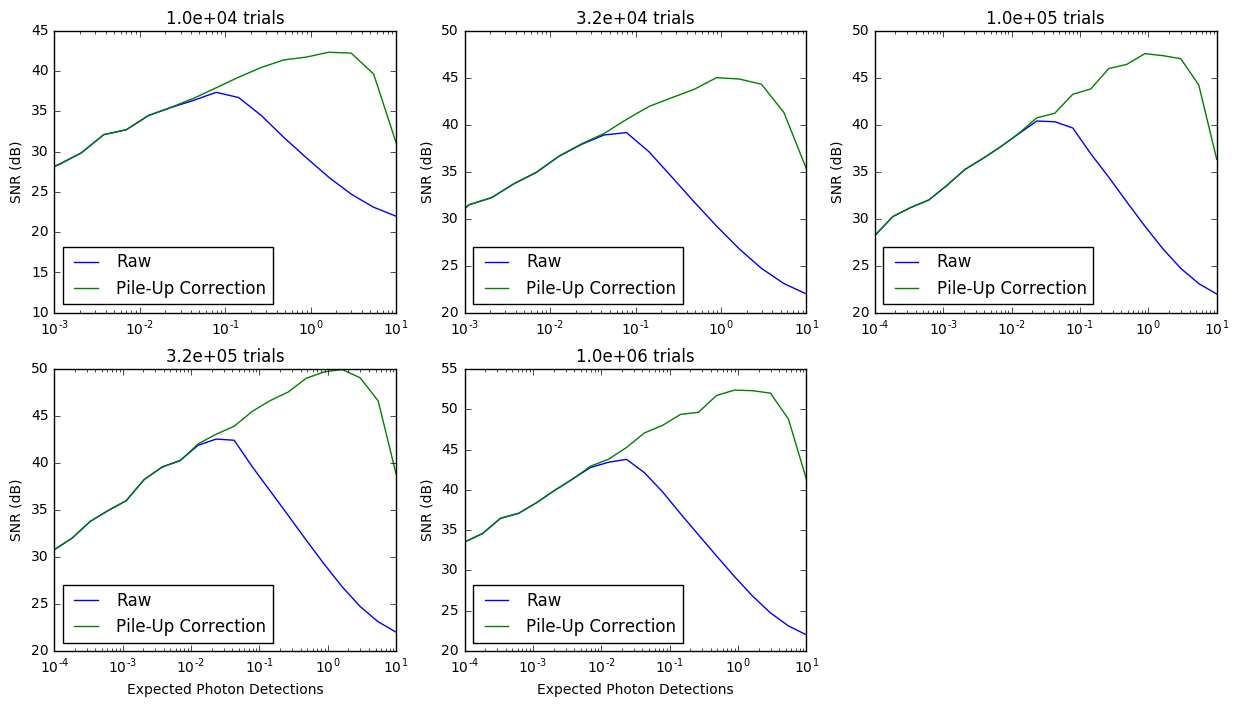

In [18]:
error_data = scipy.io.loadmat('20ps-bin-50ps-laser-SNR')
photon_count = error_data['photon_count'].flatten()
plt.figure(figsize=(15,8))
for idx, N in enumerate(error_data['num_trials'].flatten()):
    plt.subplot(2,3,idx+1)
    if idx > 2:
        plt.xlabel('Expected Photon Detections')
    plt.ylabel('SNR (dB)')
    plt.semilogx(photon_count, 10*np.log10(750/error_data['raw_error'][idx]), label='Raw')
    plt.semilogx(photon_count, 10*np.log10(750/error_data['pc_error'][idx]), label='Pile-Up Correction')
    if N in error_data['num_trials'].flatten()[:2]:
        plt.xlim([1e-3, 10])
#         plt.ylim([10, 35])
    plt.legend(loc='lower left')
    plt.title("%.1e trials" % N)
plt.savefig('20ps-bin-SNR-raw-vs-coates-50ps')

In [ ]:
# Freq vs intensity vs SNR
data = np.zeros((photons.size, len(num_trial_list)))
freqs = np.array(num_trial_list)
for i in range(photons.size):
    for j in range(freqs.size):
        data[i,j] = 10*np.log10(750/error_data['raw_error'][j][i]) #- 10*np.log10(750/error_data['raw_error'][j][i])

plt.imshow(data, aspect='auto', origin='lower',# interpolation='none', 
           extent=(np.log10(freqs.min()), np.log10(freqs.max()),np.log10(photons.min()), np.log10(photons.max())) )
plt.ylabel('Expected photon detections (log)')
plt.xlabel('Pulse freq. (log Hz)')
plt.colorbar(label='SNR (dB)')
plt.title('Raw Histogram')
# plt.savefig('raw-SNR-colormap')

In [ ]:


# scipy.io.savemat('SNR', {'photon_count':photons, 'num_trials':num_trial_list, 
# 'raw_error':np.vstack(raw_list),
# 'pc_error':np.vstack(pc_list),})

error_data = scipy.io.loadmat('SNR')
print error_data['raw_error']
print 10*np.log10(750/error_data['raw_error'][-1]).max()
print 10*np.log10(750/error_data['pc_error'][-1]).max()

In [ ]:
# BUFFER
# BUFFER
# BUFFER

In [ ]:
# Position T indicates no detection.
G1 = np.zeros((T, T))
G2 = np.zeros((T, T))
for t in range(T):
    G1[t,:] = times <= t - 1
    G2[t,:] = times <= t

# Get MAP estimate.


r = cvx.Variable(T)
lamb = QE*(r + amb) + DC
t = cvx.Variable(NUM_TRIALS)

# Gordon: choose the regularization/prior here.
# It's gamma*reg
gamma = 0
reg = cvx.sum_squares(r[1:] - r[:-1])

expr = cvx.exp(-G1*lamb) - cvx.exp(-G2*lamb)
miss = -cvx.sum_entries(lamb)
# ll_orig = buckets.T*cvx.log(expr) + miss*total_misses
total_misses = NUM_TRIALS - buckets.sum()
tmp = cvx.log(1 - cvx.exp((G1-G2)*lamb)) - G1*lamb
ll = buckets.T*tmp + miss*total_misses

prob = cvx.Problem(cvx.Maximize(ll/np.sqrt(gamma) - np.sqrt(gamma)*reg)/NUM_TRIALS, [r >= 0])
# prob = cvx.Problem(cvx.Maximize(ll)/NUM_TRIALS, [r >= 0])
# prob.solve(solver=cvx.ECOS, verbose=False)
# print "status = ", prob.status
# r_star = r.value.A.ravel()

# print "||r - r_true||_2/||r_true||_2 = ", np.linalg.norm(r_star - true_r)/np.linalg.norm(true_r)

# print ll_orig.value
# print "ll value at r =", ll.value

# print "true r"
# print true_r
# r.value = true_r
# print "ll value at true r =", ll.value

def coates(T, N, h):
    r = np.zeros(T)
    r[0] = -np.log(1-h[0]/N)
    for k in range(1,T):
        tmp = N - np.sum(h[:k])
        r[k] = -np.log(1-h[k]/tmp)
    return r

lamb_c = coates(T, NUM_TRIALS, buckets)
r_c = ((lamb_c - DC)/QE - amb)/I
print "||r_c - r_true||_2/||r_true||_2 = ", np.linalg.norm(r_c - true_r)/np.linalg.norm(true_r)

import matplotlib.pyplot as plt
plt.plot(times,true_r/true_r.sum(), linestyle='--')
# plt.plot(times, r_star/r_star.sum(), linestyle=':')
plt.plot(times, r_c/r_c.sum(), linestyle=':')
plt.plot(times, buckets/buckets.sum())
plt.legend(['True','Coates','Raw histogram']);
plt.xlabel('time');
plt.ylabel('r_t');
plt.title('Normalized Intensities')
# plt.show()

# plt.savefig('outdoors.png')


The code below is completely wrong. It makes a Gaussian after detection, not before. 

In [ ]:
np.random.seed(0)

# Constants.
I = 50 # photons/laser pulse
QE = .30; #Quantum efficiency
DC = 0;  # dark counts per exposure
amb = 0; # ambient light
c = 3e8 # speed of light

d = 3.75e-3 # distance to target

mu_laser = 0
wavelength = 455e-9 # nanometers
FWHM_laser = 500e-12 # high noise
# FWHM_laser = 128e-12 # 128 ps, low noise
sigma_laser = FWHM_laser/(2*np.sqrt(2*np.log(2)))
# FWHM = 2 sqrt(2ln(2))sigma
mu_spad = 0
FWHM_spad = 500e-12 # for high noise
# FWHM_spad = 70e-12 # 70 ps, low noise
sigma_spad = FWHM_spad/(2*np.sqrt(2*np.log(2)))
# jitter = laser jitter + SPAD jitter
# = N(mu_laser + mu_spad, sigma_spad**2 + sigma_laser**2)

# CDF G(t) = 1 - (1 - F(t))^n
# G^{-1}(t) = F^{-1}(1 - (1 - G(t))^{1/n})
# Here F(t) = jitter CDF

In [ ]:
# Model.
# photons generated (Poisson) -> iid jitter -> take min
# Poisson mean = I*QE + ambient + DC
reps = 1000; # Number of shots

def get_hist(N, I):
    mean = I
    counts = np.random.poisson(mean, size=reps)
    nnz_counts = counts[counts > 0]
    # Get times via sample inverse CDF(unif [0,1])
    unifs = np.random.uniform(size=nnz_counts.size)
    times = norm.ppf( (1 - (1 - unifs)**(1./nnz_counts)), loc=mu_laser+mu_spad,
                      scale=np.sqrt(sigma_spad**2 + sigma_laser**2) )
    # print "times = ", times
    # Make histogram.
    # 100 ps per bucket, 255 buckets
    buckets = np.arange(-50, 50)*bucket_size
    rounded = np.floor(times/bucket_size).astype(int)
    min_off = np.min(rounded)
    max_off = np.max(rounded)
    # print("max offset = %s, min offset = %s" % (max_off, min_off))
    pos_rounded = np.concatenate( [rounded + num_buckets//2, range(num_buckets)])

    hist = np.bincount(pos_rounded) - 1
    return hist

In [ ]:
get_hist(10000, 1e6)
print hist[40:50]
plt.plot(hist)

In [ ]:
def F(times, offset):
    return norm.cdf(times, loc=mu_laser+mu_spad+offset,
        scale=np.sqrt(sigma_spad**2 + sigma_laser**2))

def get_pdf(offset, mean, hist, buckets):
    # Get MAP estimate of initial time.
    # Pr(observations | t_0) = \Prod_{i=1}^N Pr(t_i in bucket I_i).
    # = Pr(t_i in bucket I_i) = \sum_{n=0}^\infty Pr(t_i in bucket I_i | n)Pr(n)
    # Pr(t_i in bucket I_i | n) = CDF(I_i max | n) - CDF(I_i min | n)
    bucket_probs = np.exp(-F(buckets, offset)*mean) - np.exp(-F(buckets + bucket_size, offset)*mean)
    prob = hist*np.log(np.maximum(bucket_probs, 1e-100))
    return prob.sum()

num_offsets = 10001
offsets = np.linspace(-bucket_size, bucket_size, num=num_offsets)
masses = np.zeros(num_offsets)
for i in range(num_offsets):
    masses[i] = get_pdf(offsets[i], hist, buckets)
print "spatial resolution in mm = ", c*bucket_size*1000
map_estimate = offsets[np.argmax(masses)]
print "MAP estimate in mm = ", c*map_estimate/2*1000

# Now fit a Gaussian.
from scipy.optimize import curve_fit
from scipy import asarray as ar, exp
SCALE = 1e9
x = (buckets + bucket_size/2)*SCALE
n = len(x)
hist_scaled = hist/hist.sum()
mean = sum(x*hist_scaled)/n                   #note this correction
sigma = sum(hist_scaled*(x-mean)**2)/n        #note this correction
def gauss(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))
popt,pcov = curve_fit(gauss,x,hist_scaled,p0=[hist_scaled.max(),mean,sigma])
_, mean, var = popt
print mean, var
estimate = mean/SCALE
print "Gaussian fit in mm = ", c*estimate/2*1000
print 500*c*(buckets[np.argmax(hist)] + bucket_size/2)

# MAP estimate in mm =  0.081 for low noise
#Gaussian fit in mm =  -15.7950009204

# MAP estimate in mm =  0.324 for high noise
# Gaussian fit in mm =  -76.8749998707

# Plot histogram
import matplotlib.pyplot as plt
# the histogram of the data
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(pos_rounded, bins=100)
plt.xlabel('Time')
plt.ylabel('Histogram count')
plt.title('Non-Gated SPAD')

plt.subplot(1,2,2)
plt.plot(offsets*c/2*1000, masses, label='Bayesian pdf')
# plt.plot(offsets, masses, label='Gaussian fit')
plt.axvline(x=estimate*c/2*1000, linestyle='-.', label='Gaussian fit')
plt.axvline(x=0, linestyle='--', label='Target', color='red')
plt.axvline(x=map_estimate*c/2*1000, linestyle=':', label='Bayesian fit')
plt.ylim([-2000,-1900])
plt.xlim([-5,5])
plt.ylabel('Log-likelihood')
plt.xlabel('Distance (mm)')
plt.legend(loc='upper left')
# plt.savefig('experiments/high-noise-single-reflector.png')
plt.show()